Автор:  Лейман М.А.  
Дата создания: 27.03.2025

# Классификация ожирения

## Модели:

Model  

logreg  

KNN  

XGBoost  

Random Forest  

LightGBM  

SVM  

BestLightGBM  

------------------------
Датасет: https://www.kaggle.com/datasets/lesumitkumarroy/obesity-data-set

### __Набор Данных для прогнозирования ожирения__  
### Оценка уровня ожирения у отдельных лиц

__Data Details:__

Gender:       пол  
Age:          возраст  
Height :      рост  
Weight :      вес   
family_history :   Страдал ли кто-либо из членов семьи избыточным весом?  
FAVC :        Часто ли вы употребляете высококалорийную пищу?  
FCVC :        Вы обычно едите овощи в своем рационе?  
NCP :         Сколько основных приемов пищи вы съедаете в день?  
CAEC :        Вы едите что-нибудь между приемами пищи?  
SMOKE :       Вы курите?  
CH2O :        Сколько воды вы выпиваете в день?  
SCC :         Вы следите за количеством калорий, которые потребляете ежедневно?  
FAF:          Как часто вы занимаетесь физической активностью?  
TUE :         Сколько времени вы проводите за использованием технологических устройств, таких как мобильный телефон, видеоигры, телевизор, компьютер и другие?  
CALC :        Как часто вы употребляете алкоголь?  
MTRANS :      Каким транспортом вы обычно пользуетесь?  
Obesity :     (Целевой столбец) Уровень ожирения  

In [ ]:
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)
print("\nДатасет: ")
!ls

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/0000_attestation

Датасет: 
attestation.ipynb  dataset1.csv


## Функции

In [ ]:
def analiz_data(data):
    ''' 
        Анализ данных
    '''
    # Выбираем только числовые столбцы
    numeric_columns = data.select_dtypes(include=[np.number])
    eda_results = pd.DataFrame({
    "Доля пропусков (%)": numeric_columns.isnull().mean() * 100,
    "Максимальное значение": numeric_columns.max(),
    "Минимальное значение": numeric_columns.min(),
    "Среднее значение": numeric_columns.mean(),
    "Медиана": numeric_columns.median(),
    "Дисперсия": numeric_columns.var(),
    "Квантиль 0.1": numeric_columns.quantile(0.1),
    "Квантиль 0.9": numeric_columns.quantile(0.9),
    "Квартиль 1 (25%)": numeric_columns.quantile(0.25),
    "Квартиль 3 (75%)": numeric_columns.quantile(0.75)
    })

    # Выбираем только категориальные столбцы
    categorical_columns = data.select_dtypes(exclude=[np.number])
    # Рассчитываем статистики
    eda_categorical = pd.DataFrame({
        "Доля пропусков (%)": categorical_columns.isnull().mean() * 100,
        "Количество уникальных значений": categorical_columns.nunique(),
        "Наиболее частое значение (мода)": categorical_columns.mode().iloc[0],
        "Частота моды (%)": categorical_columns.apply(lambda x: x.value_counts(normalize=True).iloc[0] * 100)
    })

    # Выводим результаты
    print("Числовые признаки: \n")
    print(eda_results.to_string())
    print("\nКатегориальные признаки: \n")
    print(eda_categorical.to_string())
    
    return numeric_columns, categorical_columns



def encode_categorical_features(data):
    """
    Кодирует категориальные признаки.
    
    :param data: DataFrame с данными
    :return: DataFrame с закодированными признаками
    """

    # Определяем словари для кодирования вручную
    encoding_dict = {
        'CALC': {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3},
        'CAEC': {'Sometimes': 0, 'Frequently': 1, 'Always': 2, 'no': 3},
        'MTRANS': {'Walking': 0, 'Bike': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Automobile': 4},
        'Obesity': {'Normal_Weight': 0, 'Overweight_Level_I': 1, 'Overweight_Level_II': 2,
                    'Obesity_Type_I': 3, 'Insufficient_Weight': 4, 'Obesity_Type_II': 5, 'Obesity_Type_III': 6}
    }

    # Кодируем по заданным словарям
    for col, mapping in encoding_dict.items():
        if col in data.columns:
            data[col] = data[col].map(mapping)

    # Бинарные признаки (0 и 1)
    binary_cols = ['family_history', 'FAVC', 'SMOKE', 'SCC']
    
    for col in binary_cols:
        if col in data.columns:
            data[col] = data[col].map({'yes': 1, 'no': 0})  
    # Кодирование Gender 
    if 'Gender' in data.columns:
        data['Gender'] = data['Gender'].map({'Male': 1, 'Female': 0})

    return data


def plot_histogram(data):
    ''' 
        Построение гарфиков  гистограм
    '''
    features = data.columns

    num_features = len(features)
    num_rows = (num_features + 1) // 2  

    fig, axes = plt.subplots(num_rows, 2, figsize=(14, num_rows * 4))
    axes = axes.flatten() 

    for i, feature in enumerate(features):
        sns.histplot(data[feature], kde=True, ax=axes[i])
        axes[i].set_title(f'Распределение признака "{feature}"')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()



def plot_box_plot(data):
    ''' 
        Построение графиков (ящик с усами)
    '''
    features = data.columns

    num_features = len(features)

    fig, axes = plt.subplots(1, num_features, figsize=(num_features * 3, 10))

    for i, feature in enumerate(features):
        sns.boxplot(y=data[feature], ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')

    plt.tight_layout()
    plt.show()

## 1. Загрузка данных.

In [3]:
train_df = pd.read_csv('dataset1.csv')


print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))




Размер данных:  (2111, 17)
Gender  Age  Height  Weight family_history FAVC  FCVC  NCP      CAEC SMOKE  CH2O SCC  FAF  TUE       CALC                MTRANS             Obesity
Female 21.0    1.62    64.0            yes   no   2.0  3.0 Sometimes    no   2.0  no  0.0  1.0         no Public_Transportation       Normal_Weight
Female 21.0    1.52    56.0            yes   no   3.0  3.0 Sometimes   yes   3.0 yes  3.0  0.0  Sometimes Public_Transportation       Normal_Weight
  Male 23.0    1.80    77.0            yes   no   2.0  3.0 Sometimes    no   2.0  no  2.0  1.0 Frequently Public_Transportation       Normal_Weight
  Male 27.0    1.80    87.0             no   no   3.0  3.0 Sometimes    no   2.0  no  2.0  0.0 Frequently               Walking  Overweight_Level_I
  Male 22.0    1.78    89.8             no   no   2.0  1.0 Sometimes    no   2.0  no  0.0  0.0  Sometimes Public_Transportation Overweight_Level_II


## 2. Подготовка данных

In [4]:
print("\nПропуски:")
train_df.isnull().sum()


Пропуски:


Gender            0
Age               0
Height            0
Weight            0
family_history    0
FAVC              0
FCVC              0
NCP               0
CAEC              0
SMOKE             0
CH2O              0
SCC               0
FAF               0
TUE               0
CALC              0
MTRANS            0
Obesity           0
dtype: int64

In [5]:
import pandas as pd

def explore_data(df):
    eda_results = pd.DataFrame({
        'Missing (%)': df.isnull().mean() * 100,
        'Min': df.min(numeric_only=True),
        'Max': df.max(numeric_only=True),
        'Mean': df.mean(numeric_only=True),
        'Median': df.median(numeric_only=True),
        'Variance': df.var(numeric_only=True),
        'Quantile 0.1': df.quantile(0.1, numeric_only=True),
        'Quantile 0.9': df.quantile(0.9, numeric_only=True),
        'Quartile 1': df.quantile(0.25, numeric_only=True),
        'Quartile 3': df.quantile(0.75, numeric_only=True),
    })
    return eda_results

print("EDA Анализ\n")
print(explore_data(train_df))


EDA Анализ

                Missing (%)    Min     Max       Mean     Median    Variance  \
Age                     0.0  14.00   61.00  24.312600  22.777890   40.271313   
CAEC                    0.0    NaN     NaN        NaN        NaN         NaN   
CALC                    0.0    NaN     NaN        NaN        NaN         NaN   
CH2O                    0.0   1.00    3.00   2.008011   2.000000    0.375712   
FAF                     0.0   0.00    3.00   1.010298   1.000000    0.723507   
FAVC                    0.0    NaN     NaN        NaN        NaN         NaN   
FCVC                    0.0   1.00    3.00   2.419043   2.385502    0.285078   
Gender                  0.0    NaN     NaN        NaN        NaN         NaN   
Height                  0.0   1.45    1.98   1.701677   1.700499    0.008706   
MTRANS                  0.0    NaN     NaN        NaN        NaN         NaN   
NCP                     0.0   1.00    4.00   2.685628   3.000000    0.605344   
Obesity                 0.0 

### Просмотр данных  
разделение на категориальные и числовые признаки 

In [6]:
numeric_columns, categorical_columns = analiz_data(train_df)

Числовые признаки: 

        Доля пропусков (%)  Максимальное значение  Минимальное значение  Среднее значение    Медиана   Дисперсия  Квантиль 0.1  Квантиль 0.9  Квартиль 1 (25%)  Квартиль 3 (75%)
Age                    0.0                  61.00                 14.00         24.312600  22.777890   40.271313     18.000000     33.226808         19.947192         26.000000
Height                 0.0                   1.98                  1.45          1.701677   1.700499    0.008706      1.580000      1.823755          1.630000          1.768464
Weight                 0.0                 173.00                 39.00         86.586058  83.000000  685.977477     51.154201    120.921535         65.473343        107.430682
FCVC                   0.0                   3.00                  1.00          2.419043   2.385502    0.285078      2.000000      3.000000          2.000000          3.000000
NCP                    0.0                   4.00                  1.00          2.685628   3.

#### количество уникальных значений

In [7]:
# Количество уникальных значений
categorical_columns.nunique()  


Gender            2
family_history    2
FAVC              2
CAEC              4
SMOKE             2
SCC               2
CALC              4
MTRANS            5
Obesity           7
dtype: int64

#### Просмотр уникальных значений

In [8]:
for col in categorical_columns:
    print(f"Уникальные значения в '{col}':", train_df[col].unique())


Уникальные значения в 'Gender': ['Female' 'Male']
Уникальные значения в 'family_history': ['yes' 'no']
Уникальные значения в 'FAVC': ['no' 'yes']
Уникальные значения в 'CAEC': ['Sometimes' 'Frequently' 'Always' 'no']
Уникальные значения в 'SMOKE': ['no' 'yes']
Уникальные значения в 'SCC': ['no' 'yes']
Уникальные значения в 'CALC': ['no' 'Sometimes' 'Frequently' 'Always']
Уникальные значения в 'MTRANS': ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
Уникальные значения в 'Obesity': ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


### Кодирование признаков

In [9]:
# Закодируем категориальные столбцы
train_data = encode_categorical_features(train_df)


print(train_data.head().to_string())

   Gender   Age  Height  Weight  family_history  FAVC  FCVC  NCP  CAEC  SMOKE  CH2O  SCC  FAF  TUE  CALC  MTRANS  Obesity
0       0  21.0    1.62    64.0               1     0   2.0  3.0     0      0   2.0    0  0.0  1.0     0       3        0
1       0  21.0    1.52    56.0               1     0   3.0  3.0     0      1   3.0    1  3.0  0.0     1       3        0
2       1  23.0    1.80    77.0               1     0   2.0  3.0     0      0   2.0    0  2.0  1.0     2       3        0
3       1  27.0    1.80    87.0               0     0   3.0  3.0     0      0   2.0    0  2.0  0.0     2       0        1
4       1  22.0    1.78    89.8               0     0   2.0  1.0     0      0   2.0    0  0.0  0.0     1       3        2


In [10]:
print(train_data.dtypes)


Gender              int64
Age               float64
Height            float64
Weight            float64
family_history      int64
FAVC                int64
FCVC              float64
NCP               float64
CAEC                int64
SMOKE               int64
CH2O              float64
SCC                 int64
FAF               float64
TUE               float64
CALC                int64
MTRANS              int64
Obesity             int64
dtype: object


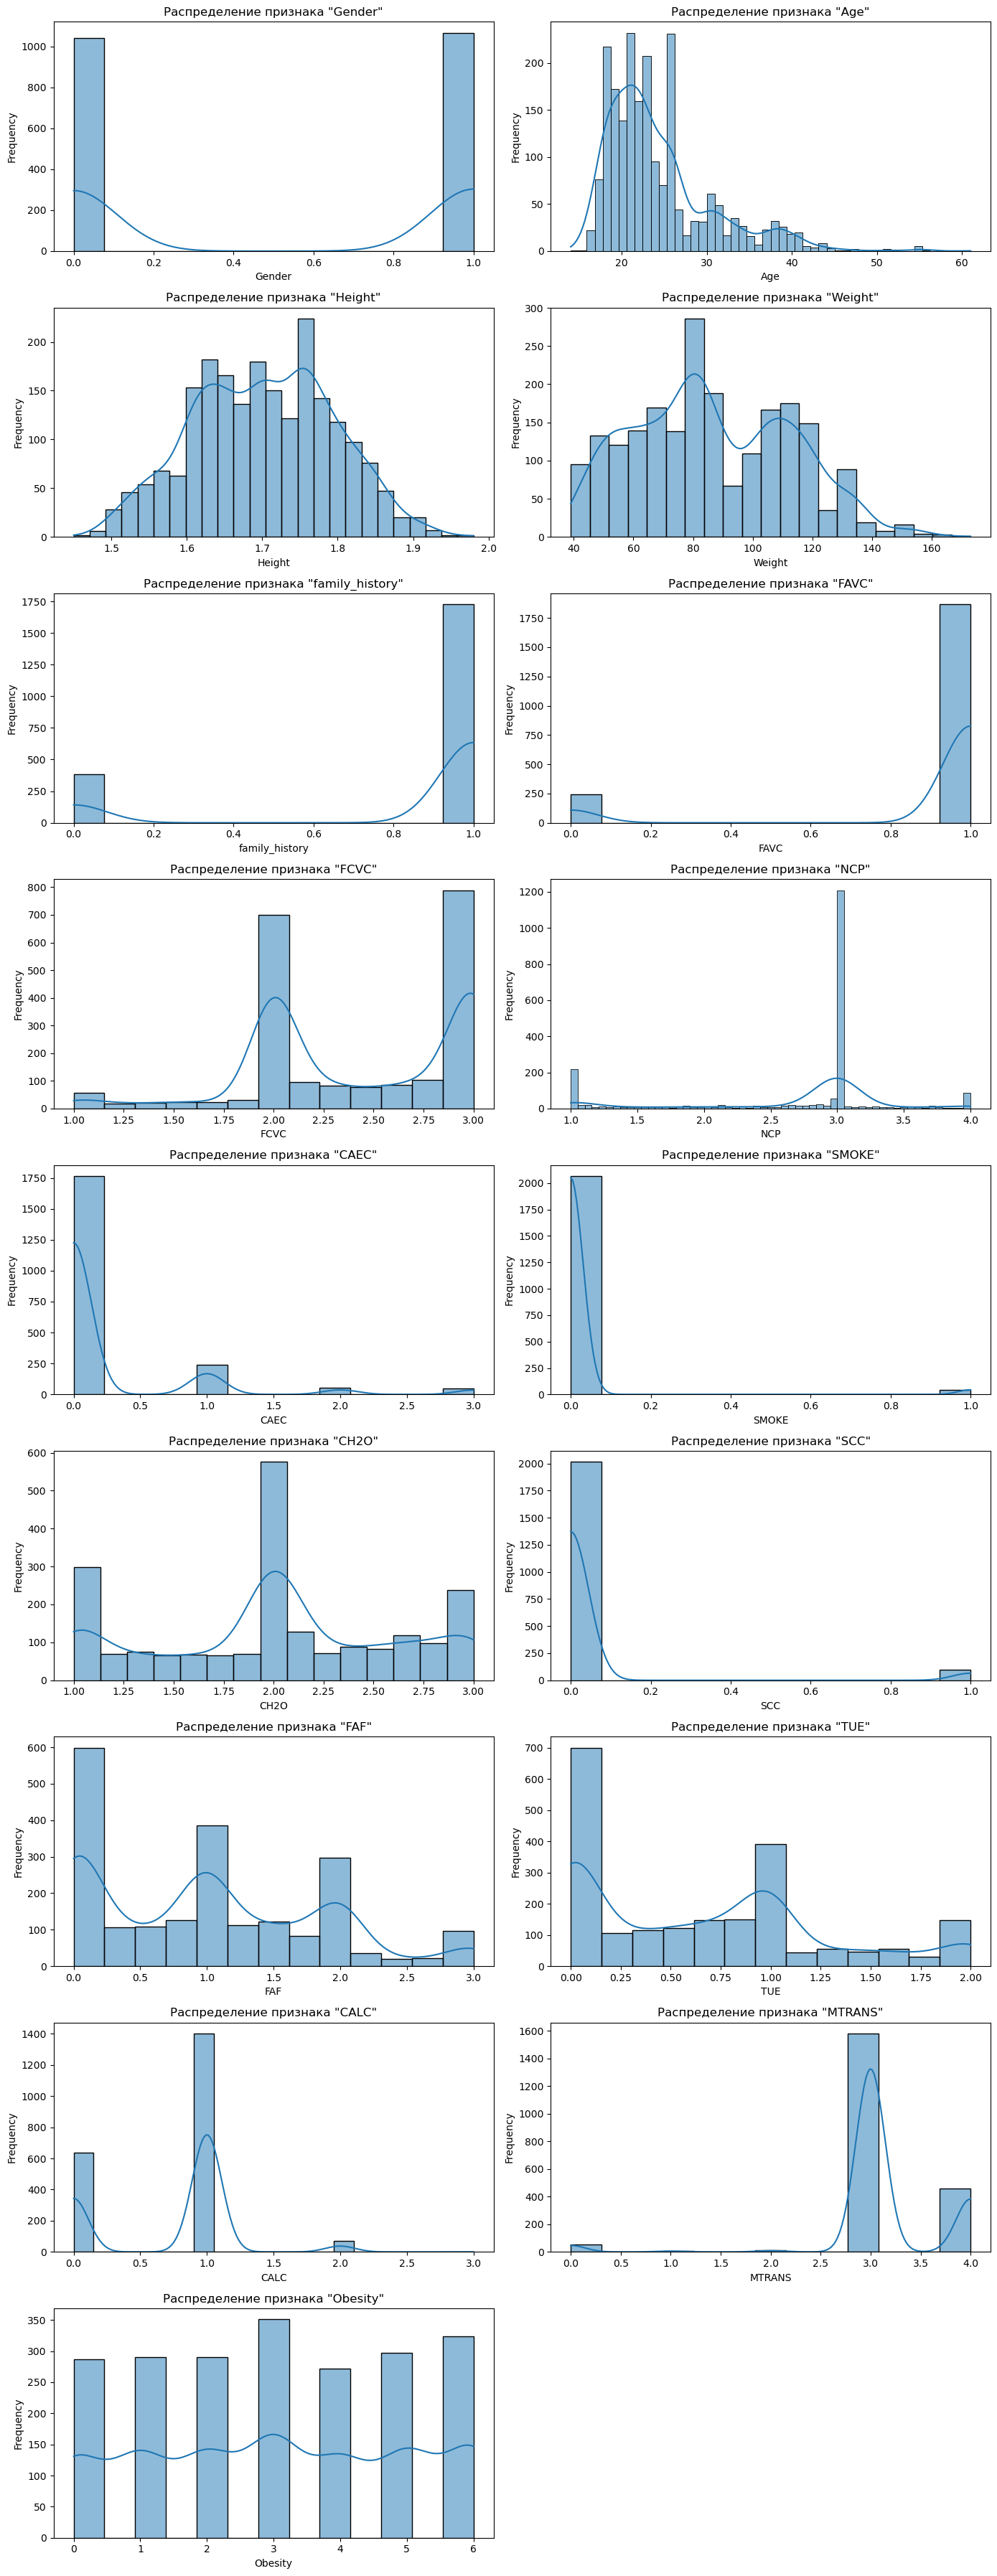

In [12]:
plot_histogram(train_data)

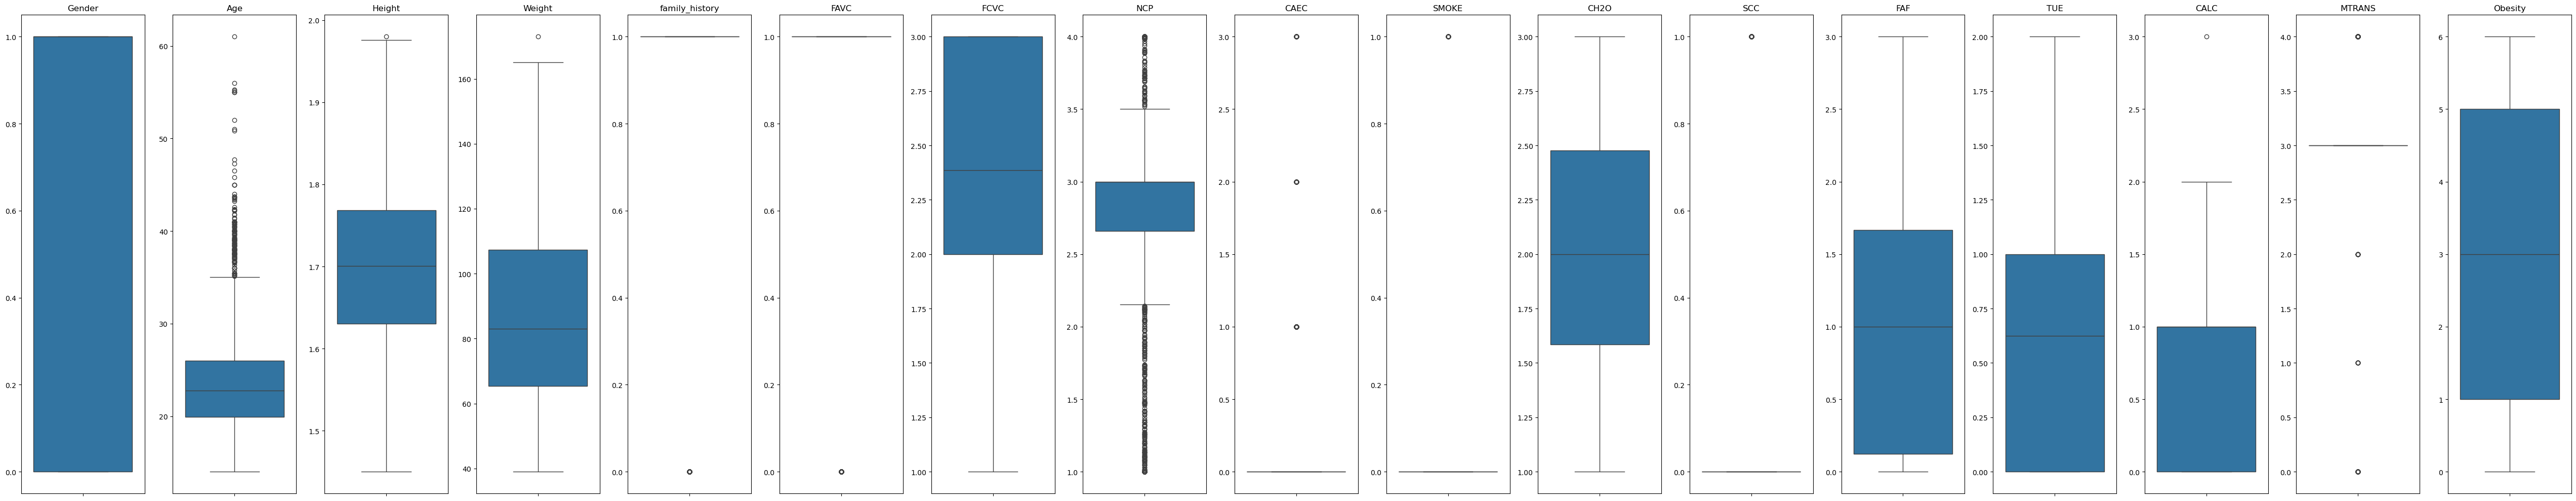

In [13]:
plot_box_plot(train_data)

CAEC             -0.272676
SCC              -0.169642
FAF              -0.142211
Gender           -0.131605
TUE              -0.034355
SMOKE            -0.030298
CH2O              0.070423
Age               0.084565
MTRANS            0.087566
CALC              0.096623
Height            0.137662
NCP               0.157947
FAVC              0.221948
family_history    0.275149
FCVC              0.343951
Weight            0.634348
Obesity           1.000000
Name: Obesity, dtype: float64


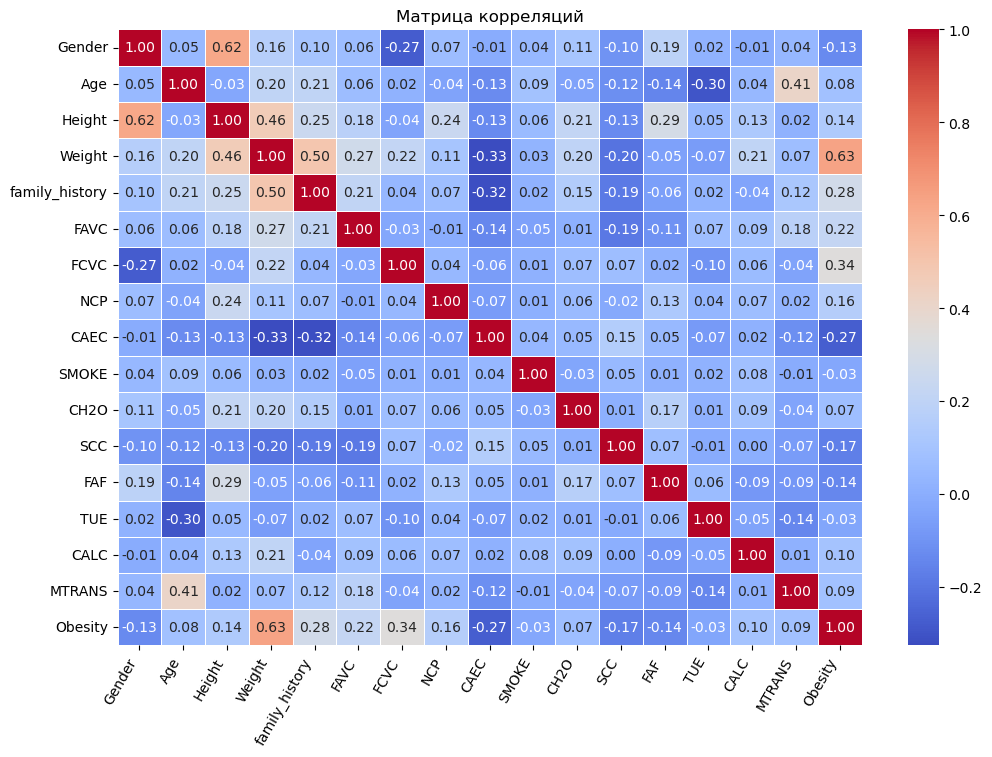

In [ ]:
# Корреляция
corr_matrix = train_data.corr()

# Выбираем корреляцию с целевой переменной
target_corr = corr_matrix["Obesity"].sort_values(ascending=True)

# Выводим признаки
print(target_corr)

# Визуализируем корреляционную матрицу
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Матрица корреляций")
plt.xticks(rotation=60, ha='right')  
plt.yticks(rotation=0) 
plt.show()

## 3. Обучение

In [ ]:
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.linear_model import LogisticRegression as cuLogisticRegression
from cuml.neighbors import KNeighborsClassifier as cuKNeighborsClassifier
from cuml.svm import SVC as cuSVC
from cuml.ensemble import RandomForestClassifier as cuRFC
from cuml.metrics.accuracy import accuracy_score  as cuml_accuracy_score
from cuml.metrics._ranking import roc_auc_score as cuml_roc_auc_score
from cuml.metrics._ranking import precision_recall_curve
from cuml.ensemble import RandomForestClassifier as cuRandomForestClassifier
import cudf
import cuml
import cupy as cp



import joblib  
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import optuna
import xgboost as xgb
import lightgbm as lgb
from flaml import AutoML

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier  
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, log_loss, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split



In [ ]:

X = train_data.drop(columns=["Obesity"]).values
y = train_data["Obesity"].values
# Разделяем данные на обучающие и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Масштабируем данные с использованием
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Словарь для хранения моделей и метрик
results = []

# Функция для сохранения результатов
def save_results(results, filename="model_results.pkl"):
    joblib.dump(results, filename)


### Логистическая регрессия

Accuracy: 0.8341232227488151
F1-Macro: 0.8222229246632988
Log Loss: 0.461288086631993


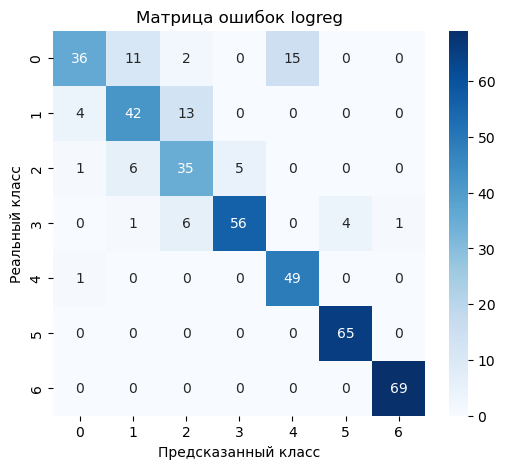

In [ ]:
# Логистическая регрессия из sklearn
logreg = LogisticRegression(max_iter=1000)

# Обучение модели
logreg.fit(X_train_scaled, y_train)

# Прогнозы
y_pred_logreg = logreg.predict(X_test_scaled)

# Преобразуем предсказания в вероятности для Log-Loss
y_pred_proba_logreg = logreg.predict_proba(X_test_scaled)

# Метрики
accuracy = accuracy_score(y_test, y_pred_logreg)
f1_macro = f1_score(y_test, y_pred_logreg, average='macro')
log_loss_value = log_loss(y_test, y_pred_proba_logreg)

# Вывод результатов
print(f"Accuracy: {accuracy}")
print(f"F1-Macro: {f1_macro}")
print(f"Log Loss: {log_loss_value}")
# Получаем уникальные классы из y_test
class_labels = sorted(np.unique(y_test))  
# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок logreg")
plt.show()


### Выберем лучшие столбцы для обучения (которые больше коррелируют с таргетом)

In [19]:
print(target_corr)

CAEC             -0.272676
SCC              -0.169642
FAF              -0.142211
Gender           -0.131605
TUE              -0.034355
SMOKE            -0.030298
CH2O              0.070423
Age               0.084565
MTRANS            0.087566
CALC              0.096623
Height            0.137662
NCP               0.157947
FAVC              0.221948
family_history    0.275149
FCVC              0.343951
Weight            0.634348
Obesity           1.000000
Name: Obesity, dtype: float64


In [ ]:
# выбор признаков с наибольшей корреляцией
selected_features = [
    'Weight', 
    'family_history', 
    'FCVC', 
    'Height', 
    'CALC',
    'Obesity'
]

train_data = train_data[selected_features]

X = train_data.drop(columns=["Obesity"]).values
y = train_data["Obesity"].values


Accuracy: 0.8767772511848341
F1-Macro: 0.8704151821463721
Log Loss: 0.5131080551612727


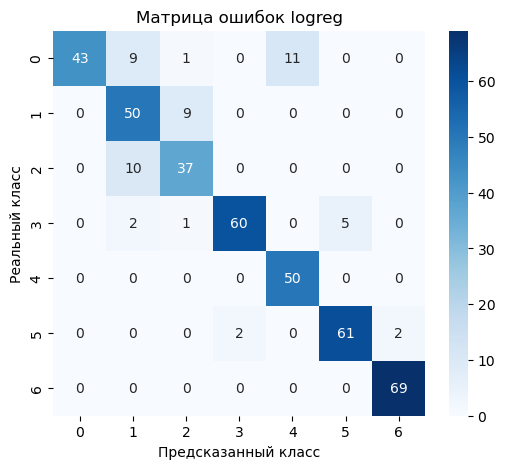

In [ ]:
# Разделяем данные на обучающие и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train_scaled, y_train)

y_pred_logreg = logreg.predict(X_test_scaled)

y_pred_proba_logreg = logreg.predict_proba(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_logreg)
f1_macro = f1_score(y_test, y_pred_logreg, average='macro')
log_loss_value = log_loss(y_test, y_pred_proba_logreg)

print(f"Accuracy: {accuracy}")
print(f"F1-Macro: {f1_macro}")
print(f"Log Loss: {log_loss_value}")

results = {
    'Model': 'logreg',
    'Accuracy': accuracy,
    'F1-Macro': f1_macro,
    'Log Loss': log_loss_value
    }

# Получаем уникальные классы из y_test
class_labels = sorted(np.unique(y_test))  
# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок logreg")
plt.show()

# Сохраняем результаты после логистической регрессии
save_results(results, "model_results_logreg.pkl")

### С уменьшенным количеством признаков получили улучшение  
__было__  
Accuracy: 0.8341232227488151  
F1-Macro: 0.8222229246632988  
Log Loss: 0.461288086631993   
__стало__  
Accuracy: 0.8767772511848341  
F1-Macro: 0.8704151821463721  
Log Loss: 0.5131080551612727  


### knn

Accuracy: 0.8744075829383886
F1-Macro: 0.8706055968417797
Log Loss: 1.5488865069991535


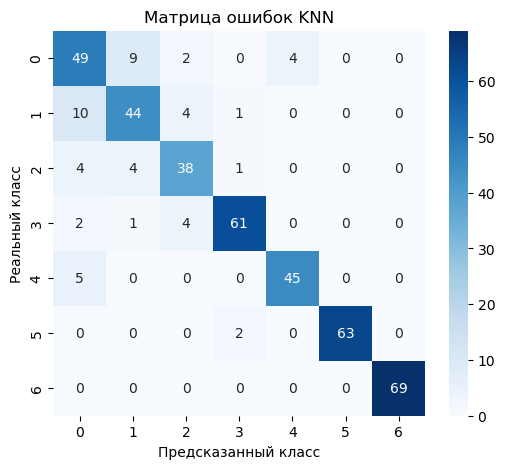

In [ ]:
# Функция для сохранения результатов
def save_results(results, filename):
    joblib.dump(results, filename)

def knn_model(X_train_scaled, X_test_scaled, y_train, y_test):
    knn = KNeighborsClassifier(n_neighbors=5)  
    knn.fit(X_train_scaled, y_train)
    
    y_pred_knn = knn.predict(X_test_scaled)
    
    y_pred_proba_knn = knn.predict_proba(X_test_scaled)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred_knn)
    f1_macro = f1_score(y_test, y_pred_knn, average='macro')
    log_loss_value = log_loss(y_test, y_pred_proba_knn)

    # Результаты
    results = {
        'Model': 'KNN',
        'Accuracy': accuracy,
        'F1-Macro': f1_macro,
        'Log Loss': log_loss_value
    }
    
    # Сохраняем результаты
    save_results(results, "model_results_knn.pkl")
    
    # Вывод результатов
    print(f"Accuracy: {accuracy}")
    print(f"F1-Macro: {f1_macro}")
    print(f"Log Loss: {log_loss_value}")

    # Получаем уникальные классы из y_test
    class_labels = sorted(np.unique(y_test))  
    # Визуализация матрицы ошибок
    # Получаем уникальные классы из y_test
    class_labels = sorted(np.unique(y_test))  
    # Визуализация матрицы ошибок
    conf_matrix = confusion_matrix(y_test, y_pred_knn)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Предсказанный класс")
    plt.ylabel("Реальный класс")
    plt.title("Матрица ошибок KNN")
    plt.show()

results_knn = knn_model(X_train_scaled, X_test_scaled, y_train, y_test)


### xgboost

Accuracy: 0.9739336492890995
F1-Macro: 0.9732921662154084
Log Loss: 0.08047270680635145


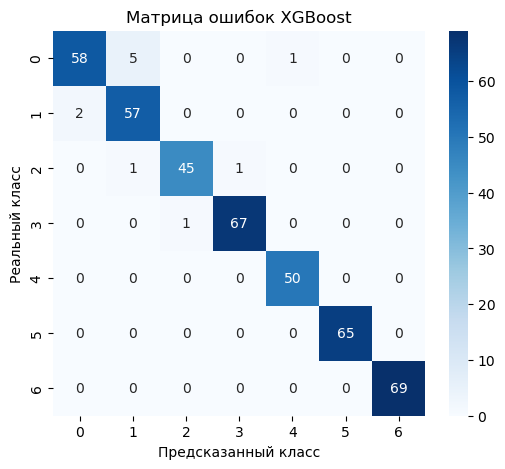

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

xgboost_model = xgb.XGBClassifier(eval_metric="mlogloss")

xgboost_model.fit(X_train_scaled, y_train)

y_pred_xgboost = xgboost_model.predict(X_test_scaled)
y_pred_proba_xgboost = xgboost_model.predict_proba(X_test_scaled)

accuracy_xgboost = accuracy_score(y_test, y_pred_xgboost)
f1_macro_xgboost = f1_score(y_test, y_pred_xgboost, average='macro')
log_loss_value_xgboost = log_loss(y_test, y_pred_proba_xgboost)

xgboost_results = {
    'Model': 'XGBoost',
    'Accuracy': accuracy_xgboost,
    'F1-Macro': f1_macro_xgboost,
    'Log Loss': log_loss_value_xgboost
}

save_results(xgboost_results, "model_results_xgboost.pkl")

print(f"Accuracy: {accuracy_xgboost}")
print(f"F1-Macro: {f1_macro_xgboost}")
print(f"Log Loss: {log_loss_value_xgboost}")

# Получаем уникальные классы из y_test
class_labels = sorted(np.unique(y_test))  
# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_xgboost)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок XGBoost")
plt.show()

### RandomForestClassifier

Random Forest Accuracy: 0.9502369668246445
Random Forest F1-Macro: 0.948203987523631
Random Forest Log Loss: 0.1791275897803113


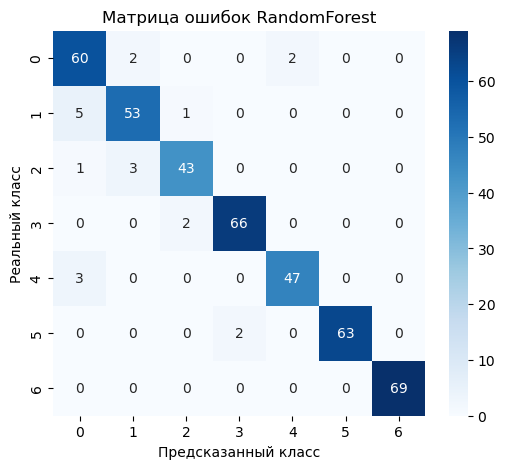

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train_scaled, y_train)

y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_macro_rf = f1_score(y_test, y_pred_rf, average="macro")
log_loss_rf = log_loss(y_test, y_pred_proba_rf)

rf_results = {
    "Model": "Random Forest",
    "Accuracy": accuracy_rf,
    "F1-Macro": f1_macro_rf,
    "Log Loss": log_loss_rf
}

joblib.dump(rf_results, "model_results_rf.pkl")

print(f"Random Forest Accuracy: {accuracy_rf}")
print(f"Random Forest F1-Macro: {f1_macro_rf}")
print(f"Random Forest Log Loss: {log_loss_rf}")

# Получаем уникальные классы из y_test
class_labels = sorted(np.unique(y_test))  
# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок RandomForest")
plt.show()



### SVC

Random SVC Accuracy: 0.9146919431279621
Random SVC F1-Macro: 0.9111104302008586
Random SVC Log Loss: 0.2619051366767681


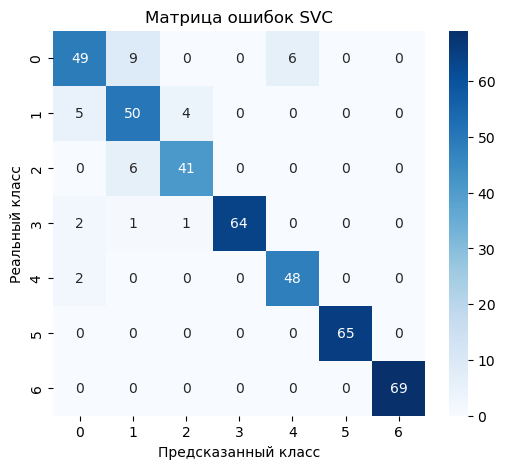

In [ ]:
# Обучение модели SVM
svm_model = SVC(probability=True, kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_proba_svm = svm_model.predict_proba(X_test_scaled)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_macro_svm = f1_score(y_test, y_pred_svm, average='macro')
log_loss_svm = log_loss(y_test, y_pred_proba_svm)

svm_results = {
    "Model": "SVM",
    "Accuracy": accuracy_svm,
    "F1-Macro": f1_macro_svm,
    "Log Loss": log_loss_svm
}
joblib.dump(svm_results, "model_results_svm.pkl")

print(f"Random SVC Accuracy: {accuracy_svm}")
print(f"Random SVC F1-Macro: {f1_macro_svm}")
print(f"Random SVC Log Loss: {log_loss_svm}")

# Получаем уникальные классы из y_test
class_labels = sorted(np.unique(y_test))  
# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок SVC")
plt.show()

### lightgbm

LightGBM Accuracy: 0.9834123222748815
LightGBM F1-Macro: 0.9830407469627868
LightGBM Log Loss: 0.07331132582048547


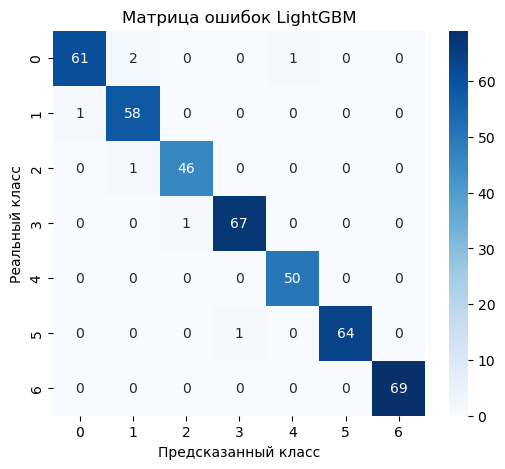

In [ ]:
# Инициализация модели LightGBM
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, verbose=-1)

# Восстанавливаем имена столбцов
# Определяем имена признаков без целевого столбца
feature_names = [col for col in selected_features if col != "Obesity"]

# Если X_test_scaled — это numpy-массив, преобразуем обратно в DataFrame
if isinstance(X_test_scaled, np.ndarray):
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Если X_train_scaled — это numpy-массив, преобразуем обратно в DataFrame
if isinstance(X_train_scaled, np.ndarray):
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)

lgb_model.fit(X_train_scaled, y_train)

y_pred_lgb = lgb_model.predict(X_test_scaled)
y_pred_proba_lgb = lgb_model.predict_proba(X_test_scaled)

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
f1_macro_lgb = f1_score(y_test, y_pred_lgb, average="macro")
log_loss_lgb = log_loss(y_test, y_pred_proba_lgb)

lgb_results = {
    "Model": "LightGBM",
    "Accuracy": accuracy_lgb,
    "F1-Macro": f1_macro_lgb,
    "Log Loss": log_loss_lgb
}

joblib.dump(lgb_results, "model_results_lgb.pkl")

# Вывод результатов
print(f"LightGBM Accuracy: {accuracy_lgb}")
print(f"LightGBM F1-Macro: {f1_macro_lgb}")
print(f"LightGBM Log Loss: {log_loss_lgb}")

# Получаем уникальные классы из y_test
class_labels = sorted(np.unique(y_test))  
# Визуализация матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_lgb)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок LightGBM")
plt.show()

### Лучшая модель lightgbm  

обучим её с подбором гиперпараметров

#### Ускорим обучение с GPU

In [ ]:
def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 3, 50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True), 
        'n_estimators': trial.suggest_int('n_estimators', 10, 150),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'device': 'gpu'  # Используем GPU
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_scaled, y_train)
    
    # X_test_df = pd.DataFrame(X_test_scaled, columns=feature_names)  
    score = model.score(X_test_scaled, y_test)  

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f"Лучшие параметры: {study.best_params}")


[I 2025-03-28 20:27:48,537] A new study created in memory with name: no-name-c7e8a0c5-2fb4-40b2-8c9a-66d9e479c8db
[I 2025-03-28 20:27:48,750] Trial 0 finished with value: 0.8672985781990521 and parameters: {'num_leaves': 6, 'learning_rate': 0.01112286439743746, 'n_estimators': 60, 'max_depth': 9}. Best is trial 0 with value: 0.8672985781990521.
[I 2025-03-28 20:27:48,981] Trial 1 finished with value: 0.976303317535545 and parameters: {'num_leaves': 14, 'learning_rate': 0.1536388202512131, 'n_estimators': 35, 'max_depth': 14}. Best is trial 1 with value: 0.976303317535545.
[I 2025-03-28 20:27:49,116] Trial 2 finished with value: 0.9075829383886256 and parameters: {'num_leaves': 10, 'learning_rate': 0.030869841502405463, 'n_estimators': 20, 'max_depth': 12}. Best is trial 1 with value: 0.976303317535545.
[I 2025-03-28 20:27:49,470] Trial 3 finished with value: 0.9312796208530806 and parameters: {'num_leaves': 47, 'learning_rate': 0.039703113237728516, 'n_estimators': 36, 'max_depth': 6}.

Лучшие параметры: {'num_leaves': 34, 'learning_rate': 0.14919800086230436, 'n_estimators': 68, 'max_depth': 7}


Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3] END learning_rate=0.08, max_depth=10, n_estimators=100, num_leaves=10;, score=0.950 total time=   0.4s
[CV 2/3] END learning_rate=0.08, max_depth=10, n_estimators=100, num_leaves=10;, score=0.950 total time=   0.4s
[CV 3/3] END learning_rate=0.08, max_depth=10, n_estimators=100, num_leaves=10;, score=0.947 total time=   0.4s
[CV 1/3] END learning_rate=0.1, max_depth=3, n_estimators=90, num_leaves=50;, score=0.945 total time=   0.2s
[CV 2/3] END learning_rate=0.1, max_depth=3, n_estimators=90, num_leaves=50;, score=0.943 total time=   0.2s
[CV 3/3] END learning_rate=0.1, max_depth=3, n_estimators=90, num_leaves=50;, score=0.959 total time=   0.2s
[CV 1/3] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=3;, score=0.702 total time=   0.1s
[CV 2/3] END learning_rate=0.01, max_depth=6, n_estimators=100, num_leaves=3;, score=0.689 total time=   0.1s
[CV 3/3] END learning_rate=0.01, max_depth=6, n_estimato

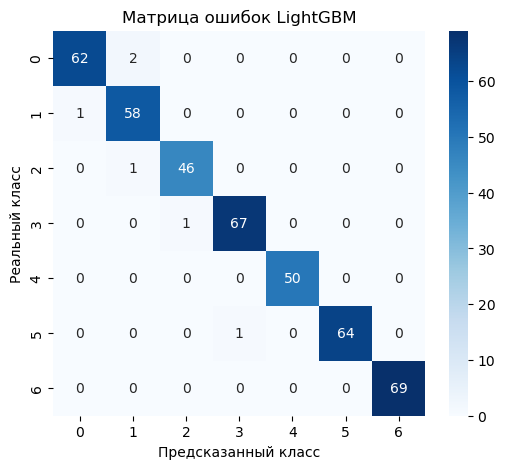

In [ ]:
lgbm = lgb.LGBMClassifier(device='gpu')  # Обучаем на GPU

param_dist = {
    'num_leaves': [3, 10, 29, 30, 31, 32, 33, 35, 40,  50],
    'learning_rate': [0.01, 0.08, 0.1, 0.15, 0.2],
    'n_estimators': [10, 50, 90, 100, 110, 150],
    'max_depth': [2, 3, 4, 5, 6, 7, 10, 15, -1]
}

random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=25, 
    cv=3,
    scoring='accuracy',
    verbose=3,
    n_jobs=1  
)

random_search.fit(X_train_scaled, y_train)

print(f"Лучшие параметры: {random_search.best_params_}")

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)  

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
log_loss_value = log_loss(y_test, y_pred_proba)

lgb_results = {
    "Model": "BestLightGBM",
    "Accuracy": accuracy,
    "F1-Macro": f1_macro,
    "Log Loss": log_loss_value
}

# Сохраняем результаты и модель
joblib.dump(lgb_results, "best_results_lgb.pkl")
joblib.dump(best_model, "best_lgbm_model.pkl")

print(f"LightGBM Accuracy: {accuracy}")
print(f"LightGBM F1-Macro: {f1_macro}")
print(f"LightGBM Log Loss: {log_loss_value}")

class_labels = sorted(np.unique(y_test))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок LightGBM")
plt.show()


#### Показала лучший результат модель с параметрами 

Лучшие параметры: {'num_leaves': 30, 'n_estimators': 100, 'max_depth': -1, 'learning_rate': 0.15}  
 
LightGBM Accuracy: 0.985781990521327  

LightGBM F1-Macro: 0.9856157433343505  

LightGBM Log Loss: 0.07728666902860531  


           Model  Accuracy  F1-Macro  Log Loss
0         logreg  0.876777  0.870415  0.513108
1            KNN  0.874408  0.870606  1.548887
2        XGBoost  0.973934  0.973292  0.080473
3  Random Forest  0.950237  0.948204  0.179128
4       LightGBM  0.983412  0.983041  0.073311
5            SVM  0.914692  0.911110  0.261905
6   BestLightGBM  0.985782  0.985616  0.077287


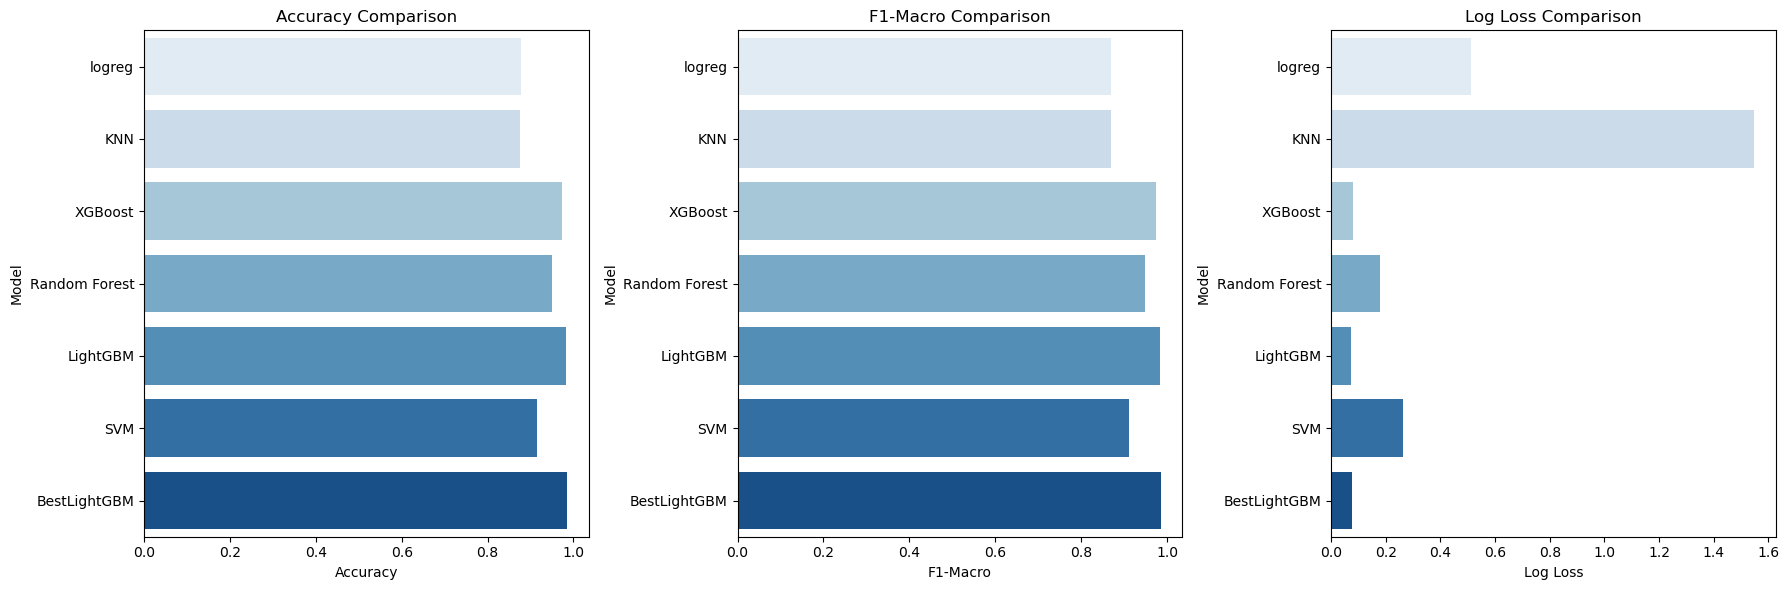

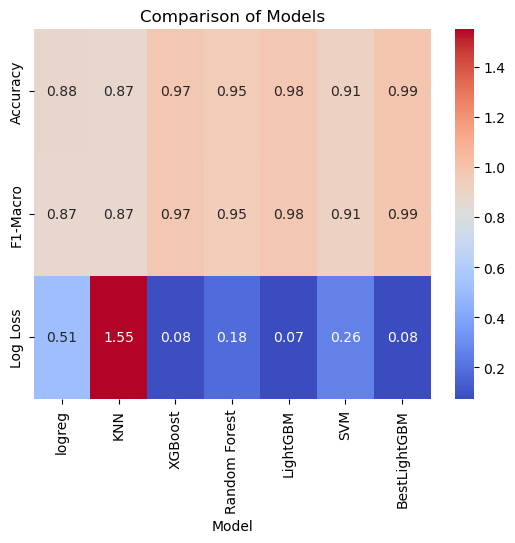

In [ ]:
# Загрузка результатов
loaded_results_logreg = joblib.load("model_results_logreg.pkl")
loaded_results_knn = joblib.load("model_results_knn.pkl")
loaded_results_xgboost = joblib.load("model_results_xgboost.pkl")
loaded_results_rf = joblib.load("model_results_rf.pkl")
loaded_results_lgb = joblib.load("model_results_lgb.pkl")
loaded_results_svm = joblib.load("model_results_svm.pkl")
loaded_results_lgb_best = joblib.load("best_results_lgb.pkl")

# Объединяем все результаты в одну таблицу
all_results = [loaded_results_logreg, loaded_results_knn, loaded_results_xgboost, loaded_results_rf, loaded_results_lgb, loaded_results_svm, loaded_results_lgb_best]

results_df = pd.DataFrame(all_results)

print(results_df)

# Бар-графики для метрик Accuracy, F1-Macro и Log Loss
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy
sns.barplot(x='Accuracy', y='Model', data=results_df, ax=axes[0], palette='Blues', hue='Model')
axes[0].set_title('Accuracy Comparison')

# F1-Macro
sns.barplot(x='F1-Macro', y='Model', data=results_df, ax=axes[1], palette='Blues', hue='Model')
axes[1].set_title('F1-Macro Comparison')

# Log Loss
sns.barplot(x='Log Loss', y='Model', data=results_df, ax=axes[2], palette='Blues', hue='Model')
axes[2].set_title('Log Loss Comparison')

plt.tight_layout()
plt.show()

# Heatmap для метрик (Accuracy, F1-Macro, Log Loss)
metrics_df = results_df[['Model', 'Accuracy', 'F1-Macro', 'Log Loss']].set_index('Model')
sns.heatmap(metrics_df.T, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Comparison of Models')
plt.show()

## 4. Применение инструментов AutoML

AutoML Accuracy: 0.9621749408983451
AutoML F1-Macro: 0.9623730254108651
AutoML Log Loss: 0.12499228224751933


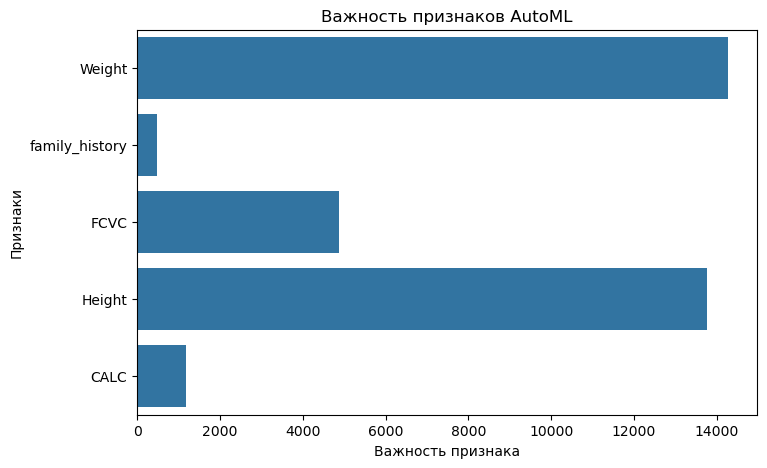

Модель сохранена!


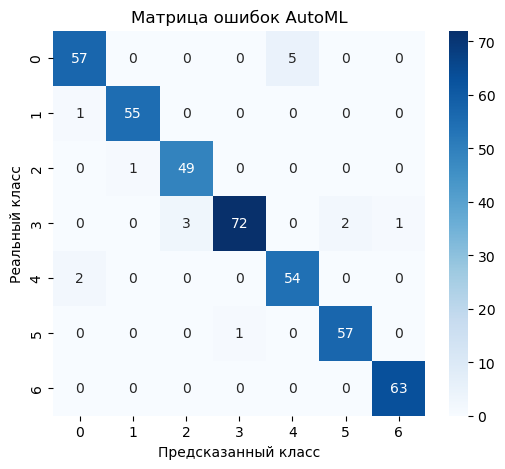

In [ ]:
selected_features = ['Weight', 'family_history', 'FCVC', 'Height', 'CALC', 'Obesity']
train_data = train_data[selected_features]

X = train_data.drop(columns=["Obesity"])
y = train_data["Obesity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

automl = AutoML()

automl.fit(
    X_train=X_train, 
    y_train=y_train,
    task="classification",
    metric="accuracy",
    time_budget=400,  
    estimator_list=["lgbm", "rf", "xgboost"],  
    verbose=2  
)

y_pred = automl.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
logloss = log_loss(y_test, automl.predict_proba(X_test))

print(f"AutoML Accuracy: {accuracy}")
print(f"AutoML F1-Macro: {f1_macro}")
print(f"AutoML Log Loss: {logloss}")

# Визуализация важности признаков
importances = automl.model.estimator.feature_importances_
features = X_train.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features)
plt.xlabel("Важность признака")
plt.ylabel("Признаки")
plt.title("Важность признаков AutoML")
plt.show()


lgb_results = {
    "Model": "AutoML",
    "Accuracy": accuracy,
    "F1-Macro": f1_macro,
    "Log Loss": log_loss_value
}

joblib.dump(lgb_results, "AutoML_results.pkl")

joblib.dump(automl, "best_automl_model.pkl")
print("Модель сохранена!")

# Визуализация матрицы ошибок
class_labels = sorted(np.unique(y_test))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Матрица ошибок AutoML")
plt.show()


           Model  Accuracy  F1-Macro  Log Loss
0         logreg  0.876777  0.870415  0.513108
1            KNN  0.874408  0.870606  1.548887
2        XGBoost  0.973934  0.973292  0.080473
3  Random Forest  0.950237  0.948204  0.179128
4       LightGBM  0.983412  0.983041  0.073311
5            SVM  0.914692  0.911110  0.261905
6   BestLightGBM  0.985782  0.985616  0.077287
7         AutoML  0.962175  0.962373  0.513108


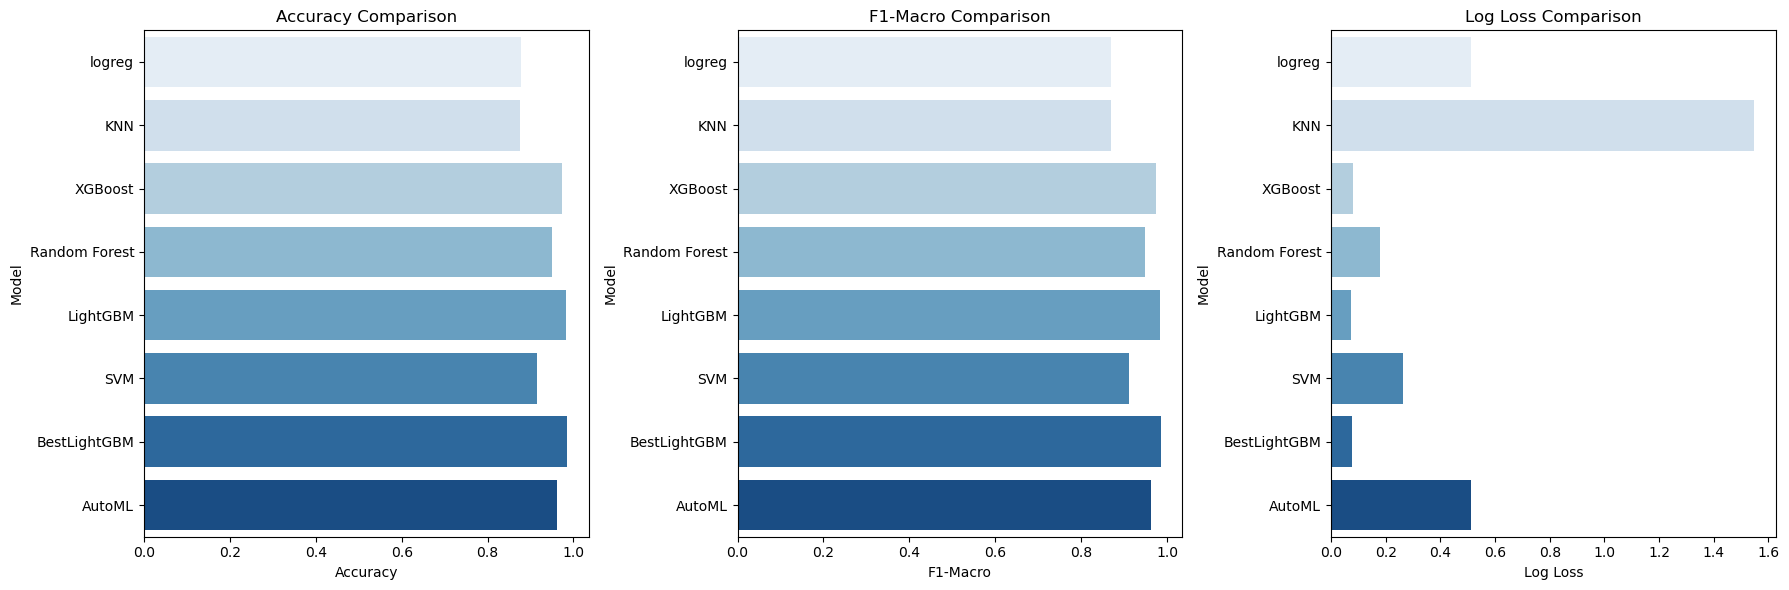

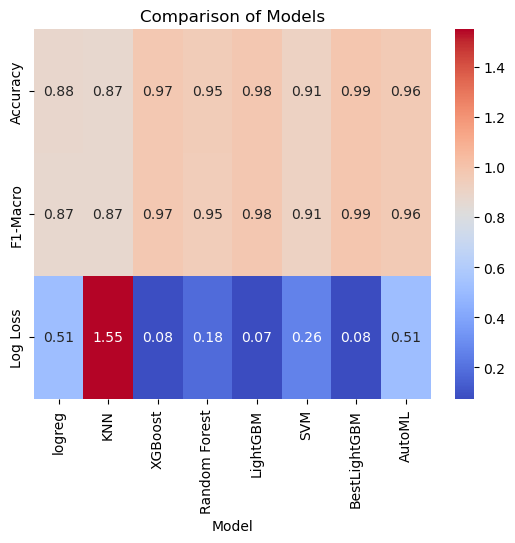

In [ ]:
# Загрузка результатов
loaded_results_logreg = joblib.load("model_results_logreg.pkl")
loaded_results_knn = joblib.load("model_results_knn.pkl")
loaded_results_xgboost = joblib.load("model_results_xgboost.pkl")
loaded_results_rf = joblib.load("model_results_rf.pkl")
loaded_results_lgb = joblib.load("model_results_lgb.pkl")
loaded_results_svm = joblib.load("model_results_svm.pkl")
loaded_results_lgb_best = joblib.load("best_results_lgb.pkl")
loaded_results_AutoML = joblib.load("AutoML_results.pkl")

# Объединяем все результаты в одну таблицу
all_results = [loaded_results_logreg, loaded_results_knn, loaded_results_xgboost, loaded_results_rf, loaded_results_lgb, loaded_results_svm, loaded_results_lgb_best, loaded_results_AutoML]

results_df = pd.DataFrame(all_results)

print(results_df)

# Бар-графики для метрик Accuracy, F1-Macro и Log Loss
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy
sns.barplot(x='Accuracy', y='Model', data=results_df, ax=axes[0], palette='Blues', hue='Model')
axes[0].set_title('Accuracy Comparison')

# F1-Macro
sns.barplot(x='F1-Macro', y='Model', data=results_df, ax=axes[1], palette='Blues', hue='Model')
axes[1].set_title('F1-Macro Comparison')

# Log Loss
sns.barplot(x='Log Loss', y='Model', data=results_df, ax=axes[2], palette='Blues', hue='Model')
axes[2].set_title('Log Loss Comparison')

plt.tight_layout()
plt.show()

# Heatmap для метрик (Accuracy, F1-Macro, Log Loss)
metrics_df = results_df[['Model', 'Accuracy', 'F1-Macro', 'Log Loss']].set_index('Model')
sns.heatmap(metrics_df.T, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Comparison of Models')
plt.show()

## Итог 

### Лучший результат показала модель __BestLightGBM__

0.985782 
   
0.985616  

0.077287